## Amplitude Analysis

In [1]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.fft import fft, ifft, fftfreq
from scipy.stats import skewnorm, norm

mpl.rc('font', size=20)
%matplotlib inline

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [2]:
include_wls = False

In [3]:
def moving_average(a, n=3, zero_padding = False, const_padding = False):
    if zero_padding:
        a = np.insert(a, np.zeros(n-1,dtype=int), np.zeros(n-1), axis=-1)
        a = np.roll(a, -int((n-1)/2), axis=-1)
    if const_padding:
        l1 = int(n/2)
        if n%2 != 1: # n is even
            l2 = l1-1
        else: # n is odd
            l2 = l1
            ind2 = -np.arange(1,(n+1)/2).astype(int)
        a = np.insert(a, np.zeros(l1, dtype=int), np.ones(l1)*a[0])
        a = np.insert(a, -np.ones(l2, dtype=int), np.ones(l2)*a[-1])
    ret = np.cumsum(a, dtype=float, axis=-1)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
#Returns binning needed to resolve a frequency.
def get_binning(sim, dt, frequency=80*u.Hz): 
    duration = sim.time[-1]-sim.time[0]
    samples = (duration/dt.to(u.s)).value
    return int((1/frequency*samples/duration).value) #binning needed to filter out sinals with f>f_lb_sasi

In [5]:
# Binning of the moving average filter defined by the Nyquist frequency of the SASI modulation
# If the sampling was to be finer the binning could be done finer, however this comes at the expense of lower
# statistics. Therefore we keep the sampling rate at 1 ms.

def get_average_signal(sim, dt, distance, frequency=80*u.Hz):
    binning = get_binning(sim, dt, frequency)

    #detector_signal s0 is not drawn from distribution
    t, s0_i3 = sim.detector_signal(dt=dt, subdetector='i3')
    t, s0_dc = sim.detector_signal(dt=dt, subdetector='dc')
    t, s0_md = sim.detector_signal(dt=dt, subdetector='md')

    s0_ic86 = s0_i3 + s0_dc
    s0_gen2 = s0_i3 + s0_dc + s0_md
    t = t.to(u.ms)

    #averaged signal sa binning size defined by the Nyquist frequency of the SASI modulation and constant padding
    sa_ic86 = moving_average(s0_ic86, n=binning, const_padding=True)
    sa_gen2 = moving_average(s0_gen2, n=binning, const_padding=True)
    
    return sa_gen2, sa_ic86

In [6]:
def min_max_in_window(array, window, return_index = False):
    x_min, x_max = np.zeros(array.shape[0]), np.zeros(array.shape[0])
    a_min, a_max = np.zeros(array.shape[0]), np.zeros(array.shape[0])
    
    ind = np.arange(array.shape[0])
    for i in np.arange(array.shape[1]-window+1):
        interval = array[:,i:i+window]
        t_min = np.min(interval, axis=1) #temporary min
        t_max = np.max(interval, axis=1) #temporary max
        t_argmin = np.argmin(interval, axis=1)+i
        t_argmax = np.argmax(interval, axis=1)+i
        mask = t_max-t_min > x_max-x_min
        x_min[ind[mask]] = t_min[ind[mask]]
        x_max[ind[mask]] = t_max[ind[mask]]
        a_min[ind[mask]] = t_argmin[ind[mask]]
        a_max[ind[mask]] = t_argmax[ind[mask]]
    if return_index:
        return x_max-x_min, a_min, a_max
    else:
        return x_max-x_min

In [7]:
dt = 0.1*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Tamborra_2014',
         'param':{
             'progenitor_mass': 20*u.Msun,
             'direction': 1}
        }
sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.006*u.s, tmax=0.338*u.s, dt=dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2',
                 include_wls = include_wls)
sim.run()

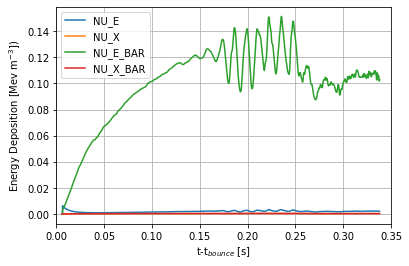

In [8]:
for flavor in sim.flavors:
    plt.plot(sim.time, sim.E_per_V[flavor], label=flavor.name)
plt.legend()
ax = plt.gca()
ax.set(xlabel=r't-t$_{bounce}$ [s]', ylabel='Energy Deposition [Mev m$^{-3}$])', xlim=(0, 0.35))
ax.grid()

In [9]:
dt = 1 * u.ms

time_wind = [150, 300] * u.ms # time dependent

In [10]:
#average background given by the mean of the sensor distribution and scaled to the full detector
ba_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
ba_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)

In [11]:
def signal_processing(sim, dt, distance, trials, minmax_window=None, dist = skewnorm, sig_method='pdf_median',
                      return_raw=False,
                      return_deviation=False, 
                      return_percentage=False, 
                      return_max_percentage=False,
                      return_test_statistics=False,
                      return_significance=False):
    
    if minmax_window == None:
        minmax_window = get_binning(sim, dt)
    
    # scale simulation with distance
    sim.scale_result(distance=distance)
    
    sa_gen2, sa_ic86 = get_average_signal(sim, dt=dt, distance=distance)
    
    # time and signal realization for each detector component
    t, s_i3 = sim.detector_hits(dt=dt, subdetector='i3', size=trials)
    t, s_dc = sim.detector_hits(dt=dt, subdetector='dc', size=trials)
    t, s_md = sim.detector_hits(dt=dt, subdetector='md', size=trials)
    #t, s_ws = sim.detector_hits(dt=dt, subdetector='ws')
    t = t.to(u.ms)

    # random background realization
    b_i3 = sim.detector.i3_bg(dt=dt, size=s_i3.shape[1]*trials)
    b_dc = sim.detector.dc_bg(dt=dt, size=s_dc.shape[1]*trials)
    b_md = sim.detector.md_bg(dt=dt, size=s_md.shape[1]*trials)
    #b_ws = sim.detector.ws_bg(dt=dt, size=len(s_ws)*trials)
    
    # reshape background
    b_i3 = b_i3.reshape(trials,s_i3.shape[1])
    b_dc = b_dc.reshape(trials,s_dc.shape[1])
    b_md = b_md.reshape(trials,s_md.shape[1])

    ### SIGNAL TRIALS ###
    s_ic86 = s_i3 + s_dc
    s_gen2 = s_i3 + s_dc + s_md
    b_ic86 = b_i3 + b_dc
    b_gen2 = b_i3 + b_dc + b_md

    # combined signal S: signal + background
    S_ic86 = s_ic86 + b_ic86
    S_gen2 = s_gen2 + b_gen2
    
    t_mask = np.logical_and(t>=time_wind[0], t<=time_wind[1])    


    # background subtraction Sb: signal + background - average background
    Sb_ic86 = S_ic86 - ba_ic86
    Sb_gen2 = S_gen2 - ba_gen2
    
    # deviation Sd: signal + background - average background - average signal
    Sd_ic86 = Sb_ic86 - sa_ic86
    Sd_gen2 = Sb_gen2 - sa_gen2

    # percentage deviation Sp: (signal + background - average background)/average signal
    Sp_ic86 = (Sb_ic86/sa_ic86)-1
    Sp_gen2 = (Sb_gen2/sa_gen2)-1
    
    Sm_ic86 = min_max_in_window(Sp_ic86[:,t_mask], window=minmax_window)
    Sm_gen2 = min_max_in_window(Sp_gen2[:,t_mask], window=minmax_window)

    ### BACKGROUND TRIALS ###
    # combined signal S: average signal + background
    B_ic86 = sa_ic86 + b_ic86
    B_gen2 = sa_gen2 + b_gen2

    # background subtraction Sb: average signal + background - average background
    Bb_ic86 = B_ic86 - ba_ic86
    Bb_gen2 = B_gen2 - ba_gen2

    # deviation Sd: average signal + background - average background - average signal = background - average background
    Bd_ic86 = b_ic86 - ba_ic86
    Bd_gen2 = b_gen2 - ba_gen2

    # percentage deviation Sp: (average signal + background - average background)/average signal
    Bp_ic86 = (Bb_ic86/sa_ic86)-1
    Bp_gen2 = (Bb_gen2/sa_gen2)-1
    
    Bm_ic86 = min_max_in_window(Bp_ic86[:,t_mask], window=minmax_window)
    Bm_gen2 = min_max_in_window(Bp_gen2[:,t_mask], window=minmax_window)
    
    # background fit parameters
    Bfp_ic86 = dist.fit(Bm_ic86)
    Bfp_gen2 = dist.fit(Bm_gen2)

    # fitted background distribution
    Bf_ic86 = dist(*Bfp_ic86)
    Bf_gen2 = dist(*Bfp_gen2)
    
    # median, 16% and 84% quantiles of TS distribution
    Sts_gen2 = np.array([np.median(Sm_gen2), np.quantile(Sm_gen2, 0.16), np.quantile(Sm_gen2, 0.84)])
    Sts_ic86 = np.array([np.median(Sm_ic86), np.quantile(Sm_ic86, 0.16), np.quantile(Sm_ic86, 0.84)])
    Bts_gen2 = np.array([np.median(Bm_gen2), np.quantile(Bm_gen2, 0.16), np.quantile(Bm_gen2, 0.84)])
    Bts_ic86 = np.array([np.median(Bm_ic86), np.quantile(Bm_ic86, 0.16), np.quantile(Bm_ic86, 0.84)])

    ### SIGNIFICANCE ###
    if sig_method == 'weighted_difference':
    # Defined as difference between the mean of the signal and background distribution devided by the square root
    # of the sum of the variance of the two distributions
        Z_ic86 = np.abs(Sm_ic86.mean()-Bm_ic86.mean())/np.sqrt(Sm_ic86.std()**2+Bm_ic86.std()**2)
        Z_gen2 = np.abs(Sm_gen2.mean()-Bm_gen2.mean())/np.sqrt(Sm_gen2.std()**2+Bm_gen2.std()**2)
    elif sig_method == 'pdf_median':
    # take the median and quantiles of the signal trials and compute the corresponding p-value/significance 
    # from the bkg distribution
        Z_ic86 = []
        Z_gen2 = []
        for i in range(3):  # loop over Sts values (median, 16%, 84% quantiles)   
        # p-value of signal given a background distribution

            p_ic86 = Bf_ic86.sf(Sts_ic86[i])
            p_gen2 = Bf_gen2.sf(Sts_gen2[i])

            # two-sided Z score corresponding to the respective p-value, survival probability = 1 - cdf
            z_ic86 = norm.isf(p_ic86/2)
            z_gen2 = norm.isf(p_gen2/2)
            
            Z_ic86.append(z_ic86)
            Z_gen2.append(z_gen2)

    if return_raw:
        return t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86
    
    if return_deviation:
        return t, Sd_gen2, Sd_ic86, Bd_gen2, Bd_ic86
    
    if return_percentage:
        return t, Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86
    
    if return_max_percentage:
        return t, Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86, Bf_gen2, Bf_ic86
    
    if return_test_statistics:
        return Sts_gen2, Sts_ic86, Bts_gen2, Bts_ic86
    
    if return_significance:
        return Sts_gen2, Sts_ic86, Bts_gen2, Bts_ic86, Z_gen2, Z_ic86

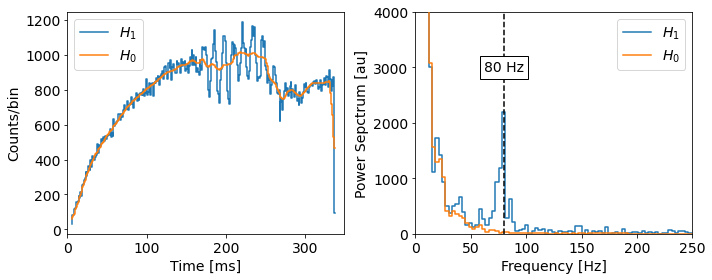

In [12]:
t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=10000, return_raw=True)

N = len(t)
T = sim._res_dt.value
      
#Fourier transformation
p_ic86 = (2.0/N * np.abs(fft(s_ic86, axis = -1)[:,1:N//2]))**2
pa_ic86 = (2.0/N * np.abs(fft(sa_ic86, axis = -1)[1:N//2]))**2
f = fftfreq(N,T)[1:N//2]


fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].step(t,s_ic86[0], color = 'C0', ls = '-', label=r'$H_{1}$', zorder = 0)
ax[0].step(t,sa_ic86, color = 'C1', ls = '-', label=r'$H_{0}$', zorder = 10)
ax[0].set_xlabel('Time [ms]', fontsize = 14)
ax[0].set_ylabel('Counts/bin', fontsize = 14)
ax[0].set_xlim(0,350)
ax[0].tick_params(labelsize = 14)
ax[0].legend(fontsize = 14)

ax[1].step(f,p_ic86[0], color = 'C0', ls = '-', label=r'$H_{1}$', zorder = 0)
ax[1].step(f,pa_ic86, color = 'C1', ls = '-', label=r'$H_{0}$', zorder = 10)
ax[1].axvline(80, color = 'black', ls = '--', zorder = 20)
ax[1].text(80, 3E3, r"80 Hz", size=14,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white', alpha = 1), zorder = 30)
ax[1].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[1].set_ylabel('Power Sepctrum [au]', fontsize = 14)
ax[1].legend(fontsize = 14)
ax[1].set_xlim(0,250)
ax[1].set_ylim(0,4000)
ax[1].tick_params(labelsize = 14)
plt.tight_layout()
#plt.savefig("../plots/hypothesis.pdf", dpi = 200)

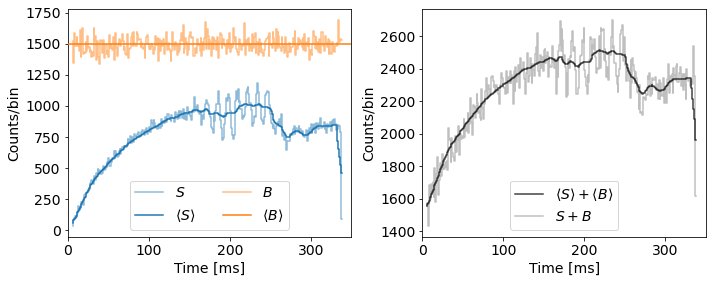

In [13]:
t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=10, return_raw=True)


fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].step(t,s_ic86[0], color = 'C0',  alpha = 0.5, ls = '-', label=r'$S$', zorder = 0)
ax[0].step(t,sa_ic86, color = 'C0', ls = '-', label=r'$\langle S \rangle$', zorder = 10)
ax[0].step(t,b_ic86[0], color = 'C1', alpha = 0.5, ls = '-', label=r'$B$', zorder = 0)
ax[0].axhline(ba_ic86, color = 'C1', ls = '-', label=r'$\langle B \rangle$', zorder = 10)

ax[0].set_xlabel('Time [ms]', fontsize = 14)
ax[0].set_ylabel('Counts/bin', fontsize = 14)
ax[0].set_xlim(0,350)
ax[0].tick_params(labelsize = 14)
ax[0].legend(ncols = 2, fontsize = 14)

ax[1].step(t,sa_ic86+ba_ic86, color = 'black',  alpha = 0.75, ls = '-', label=r'$\langle S \rangle + \langle B \rangle$', zorder = 0)
ax[1].step(t,s_ic86[0] + b_ic86[0], color = 'black',  alpha = 0.25, ls = '-', label=r'$S + B$', zorder = 0)

ax[1].set_xlabel('Time [ms]', fontsize = 14)
ax[1].set_ylabel('Counts/bin', fontsize = 14)
ax[1].set_xlim(0,350)
ax[1].tick_params(labelsize = 14)
ax[1].legend(fontsize = 14)

plt.tight_layout()
#plt.savefig("../plots/ftf_ingredients.pdf", dpi = 200)

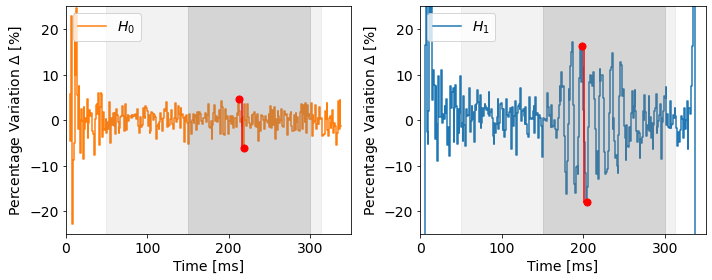

In [18]:
t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86 = signal_processing(sim, dt=dt, distance=5*u.kpc, trials=10, return_raw=True)

d0 = ((sa_ic86 + b_ic86[0] - ba_ic86)/sa_ic86 - 1) * 100
d1 = ((s_ic86[0] + b_ic86[0] - ba_ic86)/sa_ic86 -1) * 100

w1 = np.logical_and(t>=50*u.ms, t<=t[-1]-25*u.ms)    
w2 = np.logical_and(t>=150*u.ms, t<=300*u.ms)    

d0_w1 = d0[w1].reshape(1,-1)
d0_w2 = d0[w2].reshape(1,-1)
d1_w1 = d1[w1].reshape(1,-1)
d1_w2 = d1[w2].reshape(1,-1)

min_max_window = get_binning(sim, dt)

# diff and argument of min, max for both windows
d0_w1_diff, d0_w1_a1, d0_w1_a2 = min_max_in_window(d0_w1, window=min_max_window, return_index=True)
d0_w2_diff, d0_w2_a1, d0_w2_a2 = min_max_in_window(d0_w2, window=min_max_window, return_index=True)
d1_w1_diff, d1_w1_a1, d1_w1_a2 = min_max_in_window(d1_w1, window=min_max_window, return_index=True)
d1_w2_diff, d1_w2_a1, d1_w2_a2 = min_max_in_window(d1_w2, window=min_max_window, return_index=True)


# index of min, max for both windows
i0_w1 = np.array([d0_w1_a1, d0_w1_a2], dtype = 'int').flatten()
i0_w2 = np.array([d0_w2_a1, d0_w2_a2], dtype = 'int').flatten()
i1_w1 = np.array([d1_w1_a1, d1_w1_a2], dtype = 'int').flatten()
i1_w2 = np.array([d1_w2_a1, d1_w2_a2], dtype = 'int').flatten()

t0_w1, t0_w2, t1_w1, t1_w2 = [], [], [], []
a0_w1, a0_w2, a1_w1, a1_w2 = [], [], [], []

for j in range(2):
    t0_w1.append(t[w1][i0_w1[j]].value)
    t0_w2.append(t[w2][i0_w2[j]].value)
    t1_w1.append(t[w1][i1_w1[j]].value)
    t1_w2.append(t[w2][i1_w2[j]].value)
    
    a0_w1.append(d0_w1[0,i0_w1[j]])
    a0_w2.append(d0_w2[0,i0_w2[j]])
    a1_w1.append(d1_w1[0,i1_w1[j]])
    a1_w2.append(d1_w2[0,i1_w2[j]])

t0_w1 = np.array(t0_w1)
t0_w2 = np.array(t0_w2)
t1_w1 = np.array(t1_w1)
t1_w2 = np.array(t1_w2)

a0_w1 = np.array(a0_w1)
a0_w2 = np.array(a0_w2)
a1_w1 = np.array(a1_w1)
a1_w2 = np.array(a1_w2)

fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].step(t,d0, color = 'C1', ls = '-', label=r'$H_{0}$', zorder = -10)
ax[0].axvspan(150, 300, color = 'grey', alpha = 0.25)
ax[0].axvspan(50, t.value[-1]-25, color = 'grey', alpha = 0.1)
ax[0].scatter(t0_w2, a0_w2, s = 50, c = 'red', marker = 'o', alpha = 1)

ax[0].plot(((t0_w2[0]+t0_w2[1])/2,(t0_w2[0]+t0_w2[1])/2), (a0_w2[0],a0_w2[1]), color = 'r', alpha = 1)
ax[0].plot((t0_w2[0], (t0_w2[0]+t0_w2[1])/2), (a0_w2[0],a0_w2[0]), color = 'r', alpha = 1)
ax[0].plot(((t0_w2[0]+t0_w2[1])/2,t0_w2[1]), (a0_w2[1],a0_w2[1]), color = 'r', alpha = 1)

ax[0].set_xlabel('Time [ms]', fontsize = 14)
ax[0].set_ylabel('Percentage Variation $\Delta$ [%]', fontsize = 14)
ax[0].set_xlim(0,350)
ax[0].set_ylim(-25,25)
ax[0].tick_params(labelsize = 14)
ax[0].legend(ncols = 2, fontsize = 14, loc = 'upper left')

ax[1].step(t,d1, color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = -10)
ax[1].axvspan(150, 300, color = 'grey', alpha = 0.25)
ax[1].axvspan(50, t.value[-1]-25, color = 'grey', alpha = 0.1)
ax[1].scatter(t1_w2, a1_w2, s = 50, c = 'red', marker = 'o', alpha = 1)

ax[1].plot(((t1_w2[0]+t1_w2[1])/2,(t1_w2[0]+t1_w2[1])/2), (a1_w2[0],a1_w2[1]), color = 'r', alpha = 1)
ax[1].plot((t1_w2[0], (t1_w2[0]+t1_w2[1])/2), (a1_w2[0],a1_w2[0]), color = 'r', alpha = 1)
ax[1].plot(((t1_w2[0]+t1_w2[1])/2,t1_w2[1]), (a1_w2[1],a1_w2[1]), color = 'r', alpha = 1)

ax[1].set_xlabel('Time [ms]', fontsize = 14)
ax[1].set_ylabel('Percentage Variation $\Delta$ [%]', fontsize = 14)
ax[1].set_xlim(0,350)
ax[1].set_ylim(-25,25)
ax[1].tick_params(labelsize = 14)
ax[1].legend(ncols = 2, fontsize = 14, loc = 'upper left')


plt.tight_layout()
plt.savefig("../plots/ftf_ampl_percentage.pdf", dpi = 200)

In [20]:
f, Sm_gen2, Sm_ic86_10, Bm_gen2, Bm_ic86_10, Bf_gen2, Bf_ic86_10 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=100000, return_max_percentage=True)
f, Sm_gen2, Sm_ic86_20, Bm_gen2, Bm_ic86_20, Bf_gen2, Bf_ic86_20 = signal_processing(sim, dt=dt, distance=20*u.kpc, trials=100000, return_max_percentage=True)

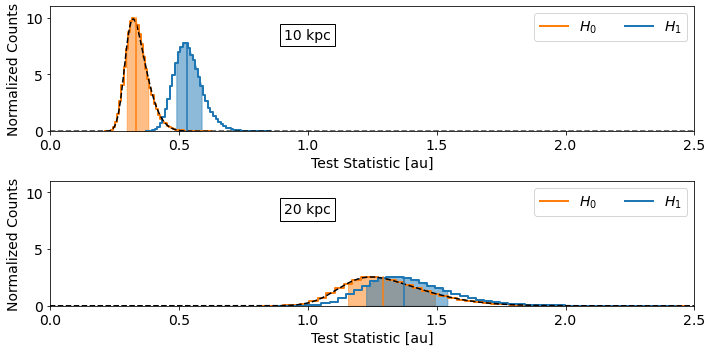

In [21]:
pp_10 = np.linspace(0, 2.5, 1000)
pp_20 = np.linspace(0, 2.5, 1000)

qs_10 = np.array([np.quantile(Sm_ic86_10, 0.14), np.quantile(Sm_ic86_10, 0.86)])
qs_20 = np.array([np.quantile(Sm_ic86_20, 0.14), np.quantile(Sm_ic86_20, 0.86)])
qb_10 = np.array([np.quantile(Bm_ic86_10, 0.14), np.quantile(Bm_ic86_10, 0.86)])
qb_20 = np.array([np.quantile(Bm_ic86_20, 0.14), np.quantile(Bm_ic86_20, 0.86)])


y_bm_ic86_10, bins_bm_ic86_10 = np.histogram(Bm_ic86_10, bins = 50, density = True)
y_sm_ic86_10, bins_sm_ic86_10 = np.histogram(Sm_ic86_10, bins = 50, density = True)
y_bm_ic86_20, bins_bm_ic86_20 = np.histogram(Bm_ic86_20, bins = 50, density = True)
y_sm_ic86_20, bins_sm_ic86_20 = np.histogram(Sm_ic86_20, bins = 50, density = True)

x_bm_ic86_10 = (bins_bm_ic86_10[:-1]+bins_bm_ic86_10[1:])/2
x_sm_ic86_10 = (bins_sm_ic86_10[:-1]+bins_sm_ic86_10[1:])/2
x_bm_ic86_20 = (bins_bm_ic86_20[:-1]+bins_bm_ic86_20[1:])/2
x_sm_ic86_20 = (bins_sm_ic86_20[:-1]+bins_sm_ic86_20[1:])/2


m_sm_ic86_10 = np.logical_and(x_sm_ic86_10 > qs_10[0], x_sm_ic86_10 < qs_10[1])
m_bm_ic86_10 = np.logical_and(x_bm_ic86_10 > qb_10[0], x_bm_ic86_10 < qb_10[1])
m_sm_ic86_20 = np.logical_and(x_sm_ic86_20 > qs_20[0], x_sm_ic86_20 < qs_20[1])
m_bm_ic86_20 = np.logical_and(x_bm_ic86_20 > qb_20[0], x_bm_ic86_20 < qb_20[1])



fig, ax = plt.subplots(2,1, figsize = (10,5)) 

ax[0].step(x_bm_ic86_10, y_bm_ic86_10, color = 'C1', ls = '-', lw = 2, label=r'$H_0$', where = 'mid')
ax[0].step(x_sm_ic86_10, y_sm_ic86_10, color = 'C0', ls = '-', lw = 2, label=r'$H_1$', where = 'mid')
ax[0].plot(pp_10, Bf_ic86_10.pdf(pp_10), color = 'k', ls = '--')

ax[0].axvline(np.median(Bm_ic86_10), ymin = 0, ymax =np.max(y_bm_ic86_10)/11, color = 'C1', ls = '-')
ax[0].axvline(np.median(Sm_ic86_10), ymin = 0, ymax =np.max(y_sm_ic86_10)/11, color = 'C0', ls = '-')
ax[0].fill_between(x = x_bm_ic86_10[m_bm_ic86_10], y1 = y_bm_ic86_10[m_bm_ic86_10], color = 'C1', alpha = 0.5)
ax[0].fill_between(x = x_sm_ic86_10[m_sm_ic86_10], y1 = y_sm_ic86_10[m_sm_ic86_10], color = 'C0', alpha = 0.5)
ax[0].text(1, 8.5, r"10 kpc", size=14,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white', alpha = 1), zorder = 30)


ax[1].step(x_bm_ic86_20, y_bm_ic86_20, color = 'C1', ls = '-', lw = 2, label=r'$H_0$', where = 'mid')
ax[1].step(x_sm_ic86_20, y_sm_ic86_20, color = 'C0', ls = '-', lw = 2, label=r'$H_1$', where = 'mid')
ax[1].plot(pp_20, Bf_ic86_20.pdf(pp_20), color = 'k', ls = '--')

ax[1].axvline(np.median(Bm_ic86_20), ymin = 0, ymax =np.max(y_bm_ic86_20)/11, color = 'C1', ls = '-')
ax[1].axvline(np.median(Sm_ic86_20), ymin = 0, ymax =np.max(y_sm_ic86_20)/11, color = 'C0', ls = '-')
ax[1].fill_between(x = x_bm_ic86_20[m_bm_ic86_20], y1 = y_bm_ic86_20[m_bm_ic86_20], color = 'C1', alpha = 0.5)
ax[1].fill_between(x = x_sm_ic86_20[m_sm_ic86_20], y1 = y_sm_ic86_20[m_sm_ic86_20], color = 'C0', alpha = 0.5)
ax[1].text(1, 8.5, r"20 kpc", size=14,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white', alpha = 1), zorder = 30)


for i in range(2):
    ax[i].set_xlabel('Test Statistic [au]', fontsize = 14)
    ax[i].set_ylabel('Normalized Counts', fontsize = 14)
    ax[i].tick_params(labelsize = 14)
    ax[i].set_xlim(0,2.5)
    ax[i].set_ylim(0,1.1E1)
    ax[i].set_xticks([0, 0.5, 1, 1.5, 2, 2.5])
    ax[i].set_yticks([0, 5, 10])
    ax[i].get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax[i].legend(ncols = 2, fontsize = 14, loc = 'upper right')
plt.tight_layout()
plt.savefig("../plots/ftf_ampl_tsdist.pdf", dpi = 200)